In [2]:
import json
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("..").resolve()
MASTER_DIR = ROOT / "data" / "master" / "master_lib.mat"
CASE_DIR =   ROOT / "data" / "cases"

def _resolve(f, x):
    while isinstance(x, h5py.Reference):
        x = f[x][()]
    if isinstance(x, np.ndarray) and x.size == 1:
        return _resolve(f, x.item())
    return x


def _matlab_str(f, x) -> str:
    x = _resolve(f, x)
    arr = np.array(x)
    if arr.dtype == np.uint16:
        return "".join(chr(c) for c in arr.flatten() if c != 0)
    if arr.shape == ():
        return str(arr.item())
    return str(arr)


def _matlab_int(f, x) -> int:
    x = _resolve(f, x)
    arr = np.array(x)
    if arr.shape == ():
        return int(arr.item())
    return int(arr.flatten()[0])


def deer_contour_from_mat(mat_path, *, category="deer", img_id=300):
    with h5py.File(mat_path, "r") as f:
        rec = f["records"]
        ds_cat = rec["category"]
        ds_id = rec["img_id"]
        ds_contour = rec["contour"]

        idx = None
        for i in range(ds_id.size):
            if _matlab_str(f, ds_cat[i]) == category and _matlab_int(f, ds_id[i]) == int(img_id):
                idx = i
                break
        if idx is None:
            raise ValueError(f"No record found for category='{category}', img_id={img_id}")

        contour = np.array(_resolve(f, ds_contour[idx]))

    if contour.ndim != 2:
        raise ValueError(f"Contour is not 2D, got {contour.shape}")
    if contour.shape[0] == 2 and contour.shape[1] != 2:
        contour = contour.T
    if contour.shape[1] != 2:
        raise ValueError(f"Expected Nx2 contour, got {contour.shape}")

    return contour.astype(float)


def add_oval_occluder_normcoords_plot_and_save_jsonl(
    mat_path: str,
    *,
    category: str = "deer",
    img_id: int = 300,

    # OVAL parameters you asked for
    occ_rx: float = 0.11,         # radius in x (half-width) in normalized space
    occ_ry: float = 0.08,         # radius in y (half-height) in normalized space

    # placement control
    occ_mode: str = "random",     # "center", "random", or "manual"
    occ_cx: float | None = None,  # manual center x
    occ_cy: float | None = None,  # manual center y

    # plotting and saving
    alpha: float = 0.6,
    jsonl_path: str = "deer_300_occ.jsonl",
    seed: int = 7,
    show: bool = True,

    # oval smoothness
    n_ellipse_pts: int = 80,
):
    rng = np.random.default_rng(seed)

    c = deer_contour_from_mat(mat_path, category=category, img_id=img_id)
    c_plot = np.vstack([c, c[0]]) if not np.allclose(c[0], c[-1]) else c

    min_xy = c.min(axis=0)
    max_xy = c.max(axis=0)

    # choose center
    if occ_mode == "center":
        cx = 0.5 * (min_xy[0] + max_xy[0])
        cy = 0.5 * (min_xy[1] + max_xy[1])
    elif occ_mode == "random":
        p = c[rng.integers(0, c.shape[0])]
        cx = float(p[0])
        cy = float(p[1])
    elif occ_mode == "manual":
        if occ_cx is None or occ_cy is None:
            raise ValueError("For occ_mode='manual', you must pass occ_cx and occ_cy.")
        cx = float(occ_cx)
        cy = float(occ_cy)
    else:
        raise ValueError("occ_mode must be 'center', 'random', or 'manual'")

    # clamp center so the oval stays within contour bounding box
    cx = float(np.clip(cx, min_xy[0] + occ_rx, max_xy[0] - occ_rx))
    cy = float(np.clip(cy, min_xy[1] + occ_ry, max_xy[1] - occ_ry))

    # build oval polygon points
    t = np.linspace(0.0, 2.0 * np.pi, int(n_ellipse_pts), endpoint=False)
    oval = np.column_stack([cx + occ_rx * np.cos(t), cy + occ_ry * np.sin(t)]).astype(float)

    fig = ax = None
    if show:
        fig, ax = plt.subplots(figsize=(5, 5))

        ax.fill(c_plot[:, 0], c_plot[:, 1],
                color="black", linewidth=0, zorder=1)

        ax.fill(oval[:, 0], oval[:, 1],
                color="#838383", linewidth=0, alpha=1, zorder=2)

        ax.set_aspect("equal")
        ax.invert_yaxis()
        ax.axis("off")
        ax.set_facecolor("white")

        pad = 0.02
        ax.set_xlim(min_xy[0] - pad, max_xy[0] + pad)
        ax.set_ylim(max_xy[1] + pad, min_xy[1] - pad)

        plt.show()

    # IMPORTANT: keep the SAME JSONL keys as the rectangle version
    row = {
        "ts_utc": time.time(),
        "source_mat": mat_path,
        "category": category,
        "img_id": int(img_id),
        "coord_system": "normalized_contour_space",
        "shape_contour_xy": c.tolist(),

        # same key name, but contains the oval polygon (Nx2)
        "occluder_rect_xy": oval.tolist(),

        # same key name/structure. w,h correspond to the oval's bounding box
        "occluder_rect_wh": {"w": float(2.0 * occ_rx), "h": float(2.0 * occ_ry)},

        "occluder_mode": occ_mode,
        "seed": int(seed),
        "plotting": {"invert_yaxis": True, "alpha": float(alpha)},
        "shape_bounds": {"min": min_xy.tolist(), "max": max_xy.tolist()},
    }

    with open(jsonl_path, "a", encoding="utf-8") as f:
        f.write(json.dumps(row) + "\n")

    return row, (fig, ax)


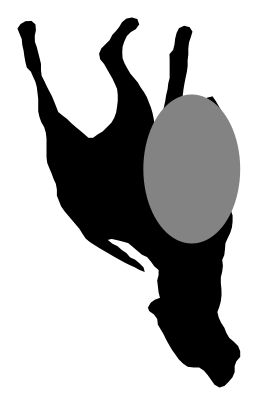

In [3]:
category="dog"
img_id = 5
JSON_DIR = CASE_DIR / f"{category}_{img_id}" / "generated"

for d in [JSON_DIR]:
    d.mkdir(parents=True, exist_ok=True)

row, _ = add_oval_occluder_normcoords_plot_and_save_jsonl(
     "/Users/I743312/Documents/monte-carlo-selection/data/master/master_lib.mat",
     category=category,
     img_id=img_id,
     occ_rx=0.13,
     occ_ry=0.2,
     occ_mode="manual",
     occ_cx=0.7,
     occ_cy=0.41,
     jsonl_path= JSON_DIR / f"{category}_{img_id}.jsonl",
     seed=8,
     show=True
 )